<a href="https://colab.research.google.com/github/zoedesimone/wwr-semantic-segmentation/blob/main/SegFormer_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segformer Finetuning

This notebook is a modified version of the [Segformer](https://arxiv.org/abs/2105.15203) colab for the purposes of semantic segmentation of Windows.

In this notebook, we are going to fine-tune `SegFormerForSemanticSegmentation` on a custom **semantic segmentation** dataset. In semantic segmentation, the goal for the model is to label each pixel of an image with one of a list of predefined classes.

We load the encoder of the model with weights pre-trained on ImageNet-1k, and fine-tune it together with the decoder head, which starts with randomly initialized weights.

To avoid this notebook from disconnecting go to developer settings --> paste this in the console

```
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button").click()
}setInterval(ClickConnect,60000)
```



#Installs

In [1]:
!pip install -q transformers datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.6 MB/s eta 0:00:00


#Imports

In [2]:
import requests         # for sending HTTP requests and retrieving responses
import zipfile          # for working with ZIP archives
import io               # for working with input/output streams
from datasets import load_dataset   # for loading datasets
from torch.utils.data import Dataset # for creating PyTorch Dataset class
import os               # for working with files and directories in the operating system
from PIL import Image   # for working with images
from transformers import SegformerFeatureExtractor    # for extracting features using Segformer
from torch.utils.data import DataLoader   # for creating PyTorch DataLoader class

from transformers import SegformerForSemanticSegmentation   # for creating Segformer models
import json             # for working with JSON files
from huggingface_hub import cached_download, hf_hub_url    # for downloading files from Hugging Face Hub

from datasets import load_metric   # for computing evaluation metric (IOU)

import torch            # PyTorch library for creating and training neural networks
from torch import nn     # for creating neural network layers and loss functions
from sklearn.metrics import accuracy_score  # for computing accuracy score
from tqdm.notebook import tqdm    # for displaying progress bar in Jupyter notebook

import numpy as np      # for working with arrays
import matplotlib.pyplot as plt     # for plotting graphs

import pandas as pd     # for working with data in tabular form (like CSV, Excel files)

import shutil
import random
from torchvision import transforms

In [3]:
torch.manual_seed(1) #for replicability

#Connect to Google Drive
Download window dataset - there are multiple, check which one you want.

In [5]:
!gdown 'https://drive.google.com/uc?id=1PRywSwrrLwdUj2ZZF8Ypq4ND4lMfHQns'

!mkdir "segformer_10_percent_dataset"
!unzip images.zip

!gdown 'https://drive.google.com/uc?id=19oazmFAOJl8OISmgE7zzIwCFkGFK_4f6'
!unzip annotations.zip

!mv images segformer_10_percent_dataset/images
!mv annotations segformer_10_percent_dataset/annotations

Downloading...
From (original): https://drive.google.com/uc?id=1PRywSwrrLwdUj2ZZF8Ypq4ND4lMfHQns
From (redirected): https://drive.google.com/uc?id=1PRywSwrrLwdUj2ZZF8Ypq4ND4lMfHQns&confirm=t&uuid=23cc3af4-65c2-4404-a22c-a702734952ea
To: /content/images.zip
100% 61.0M/61.0M [00:00<00:00, 148MB/s]
mkdir: cannot create directory ‘segformer_10_percent_dataset’: File exists
Archive:  images.zip
  inflating: images/testing/02324.jpg  
  inflating: images/testing/00004.jpg  
  inflating: images/testing/00692.jpg  
  inflating: images/testing/02196.jpg  
  inflating: images/testing/02077.jpg  
  inflating: images/testing/01122.jpg  
  inflating: images/testing/02581.jpg  
  inflating: images/testing/01187.jpg  
  inflating: images/testing/02725.jpg  
  inflating: images/testing/02607.jpg  
  inflating: images/testing/01799.jpg  
  inflating: images/testing/01767.jpg  
  inflating: images/testing/01111.jpg  
  inflating: images/testing/01112.jpg  
  inflating: images/validation/01042.jpg  
  in

In [7]:
root_dir = 'segformer_10_percent_dataset'

# Define PyTorch dataset and dataloaders

Here we define a [custom PyTorch dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html). Each item of the dataset consists of an image and a corresponding segmentation map.

##Define the Model

In [8]:
class SemanticSegmentationDataset(Dataset):
    """Image (semantic) segmentation dataset."""

    def __init__(self, root_dir, feature_extractor, train=True):
        """
        Args:
            root_dir (string): Root directory of the dataset containing the images + annotations.
            feature_extractor (SegFormerFeatureExtractor): feature extractor to prepare images + segmentation maps.
            train (bool): Whether to load "training" or "validation" images + annotations.
        """
        self.root_dir = root_dir
        self.feature_extractor = feature_extractor
        self.train = train

        sub_path = "training" if self.train else "validation"
        self.img_dir = os.path.join(self.root_dir, "images", sub_path)
        self.ann_dir = os.path.join(self.root_dir, "annotations", sub_path)

        # read images
        image_file_names = []
        for root, dirs, files in os.walk(self.img_dir):
          image_file_names.extend(files)
        self.images = sorted(image_file_names)

        # read annotations
        annotation_file_names = []
        for root, dirs, files in os.walk(self.ann_dir):
          annotation_file_names.extend(files)
        self.annotations = sorted(annotation_file_names)

        assert len(self.images) == len(self.annotations), "There must be as many images as there are segmentation maps"

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        image = Image.open(os.path.join(self.img_dir, self.images[idx]))
        segmentation_map = Image.open(os.path.join(self.ann_dir, self.annotations[idx]))

        # randomly crop + pad both image and segmentation map to same size
        data_format = 'channels_first'
        encoded_inputs = self.feature_extractor(image, segmentation_map, return_tensors="pt",data_format = data_format)

        for k,v in encoded_inputs.items():
         encoded_inputs[k].squeeze_() # remove batch dimension

        return encoded_inputs

Let's initialize the training + validation datasets. Important: we initialize the feature extractor with `reduce_labels=True`, as the classes in ADE20k go from 0 to 150, with 0 meaning "background". However, we want the labels to go from 0 to 149, and only train the model to recognize the 150 classes (which don't include "background"). Hence, we'll reduce all labels by 1 and replace 0 by 255, which is the `ignore_index` of SegFormer's loss function.

In [9]:
from transformers import SegformerFeatureExtractor

In [10]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

train_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor)
valid_dataset = SemanticSegmentationDataset(root_dir=root_dir, feature_extractor=feature_extractor, train=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(valid_dataset))

Number of training examples: 224
Number of validation examples: 28


In [12]:
from torch.utils.data import DataLoader

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=False, num_workers = 2)
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers = 2)
#num_workers parallelizes image loading

## Define the model

Here we load the model, and equip the encoder with weights pre-trained on ImageNet-1k (we take the smallest variant, `nvidia/mit-b0` here, but you can take a bigger one like `nvidia/mit-b5` from the [hub](https://huggingface.co/models?other=segformer)). We also set the `id2label` and `label2id` mappings, which will be useful when performing inference.

In [14]:
from transformers import SegformerForSemanticSegmentation
import json
from huggingface_hub import cached_download, hf_hub_url

In [15]:
!wget -nc -O ade20k-id2label.json https://www.dropbox.com/s/zuuyk5a7iqqywcz/ade20k-id2label.json?dl=0

--2024-01-29 02:45:31--  https://www.dropbox.com/s/zuuyk5a7iqqywcz/ade20k-id2label.json?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/zuuyk5a7iqqywcz/ade20k-id2label.json [following]
--2024-01-29 02:45:31--  https://www.dropbox.com/s/raw/zuuyk5a7iqqywcz/ade20k-id2label.json
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc25d466f321d13929efe740d74c.dl.dropboxusercontent.com/cd/0/inline/CMOaHoUnyM6A_Ym3S85Ro0rv2wKzIyPsd64RsnoaFEbEITuBO6LmyIYYTgtLGSzBErvBJHLY8rwKWb_hN7r5ral7gh1bciQXS3J2J3GFgqiSWZ6QrF2tsTgQolIhJxBMy1FuTk66w5odTq95gpaigjcE/file# [following]
--2024-01-29 02:45:31--  https://uc25d466f321d13929efe740d74c.dl.dropboxusercontent.com/cd/0/inline/CMOaHoUnyM6A_Ym3S85Ro0rv2wKzIyPsd64RsnoaFEbEITuBO6LmyIYYTgtLGSzBErvBJHLY8

In [16]:
repo_id = "datasets/huggingface/label-files"
id2label = json.load(open('ade20k-id2label.json')) # load id2label mapping from a JSON on the hub
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

# define model
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/328M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.linear_fuse.weight', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.classifier.weight', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.classifier.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.batch_norm.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.0.proj.bias', 'decode_head.batch_norm.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Fine-tune the model

Here we fine-tune the model in native PyTorch, using the AdamW optimizer. We use the same learning rate as the one reported in the [paper](https://arxiv.org/abs/2105.15203).

It's also very useful to track metrics during training. For semantic segmentation, typical metrics include the mean intersection-over-union (mIoU) and pixel-wise accuracy. These are available in the Datasets library. We can load it as follows:

In [17]:
from datasets import load_metric

In [18]:
metric = load_metric("mean_iou")

<ipython-input-18-cc08e9eb9706>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("mean_iou")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:752: FutureWarning: The repository for mean_iou contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.16.1/metrics/mean_iou/mean_iou.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [19]:
!mkdir segformer_model_results/
!mkdir segformer_model_results/full_dataset/

In [20]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [[120, 120, 120], [180, 120, 120], [6, 230, 230], [80, 50, 50],
            [4, 200, 3], [120, 120, 80], [140, 140, 140], [204, 5, 255],
            [230, 230, 230], [4, 250, 7], [224, 5, 255], [235, 255, 7],
            [150, 5, 61], [120, 120, 70], [8, 255, 51], [255, 6, 82],
            [143, 255, 140], [204, 255, 4], [255, 51, 7], [204, 70, 3],
            [0, 102, 200], [61, 230, 250], [255, 6, 51], [11, 102, 255],
            [255, 7, 71], [255, 9, 224], [9, 7, 230], [220, 220, 220],
            [255, 9, 92], [112, 9, 255], [8, 255, 214], [7, 255, 224],
            [255, 184, 6], [10, 255, 71], [255, 41, 10], [7, 255, 255],
            [224, 255, 8], [102, 8, 255], [255, 61, 6], [255, 194, 7],
            [255, 122, 8], [0, 255, 20], [255, 8, 41], [255, 5, 153],
            [6, 51, 255], [235, 12, 255], [160, 150, 20], [0, 163, 255],
            [140, 140, 140], [250, 10, 15], [20, 255, 0], [31, 255, 0],
            [255, 31, 0], [255, 224, 0], [153, 255, 0], [0, 0, 255],
            [255, 71, 0], [0, 235, 255], [0, 173, 255], [31, 0, 255],
            [11, 200, 200], [255, 82, 0], [0, 255, 245], [0, 61, 255],
            [0, 255, 112], [0, 255, 133], [255, 0, 0], [255, 163, 0],
            [255, 102, 0], [194, 255, 0], [0, 143, 255], [51, 255, 0],
            [0, 82, 255], [0, 255, 41], [0, 255, 173], [10, 0, 255],
            [173, 255, 0], [0, 255, 153], [255, 92, 0], [255, 0, 255],
            [255, 0, 245], [255, 0, 102], [255, 173, 0], [255, 0, 20],
            [255, 184, 184], [0, 31, 255], [0, 255, 61], [0, 71, 255],
            [255, 0, 204], [0, 255, 194], [0, 255, 82], [0, 10, 255],
            [0, 112, 255], [51, 0, 255], [0, 194, 255], [0, 122, 255],
            [0, 255, 163], [255, 153, 0], [0, 255, 10], [255, 112, 0],
            [143, 255, 0], [82, 0, 255], [163, 255, 0], [255, 235, 0],
            [8, 184, 170], [133, 0, 255], [0, 255, 92], [184, 0, 255],
            [255, 0, 31], [0, 184, 255], [0, 214, 255], [255, 0, 112],
            [92, 255, 0], [0, 224, 255], [112, 224, 255], [70, 184, 160],
            [163, 0, 255], [153, 0, 255], [71, 255, 0], [255, 0, 163],
            [255, 204, 0], [255, 0, 143], [0, 255, 235], [133, 255, 0],
            [255, 0, 235], [245, 0, 255], [255, 0, 122], [255, 245, 0],
            [10, 190, 212], [214, 255, 0], [0, 204, 255], [20, 0, 255],
            [255, 255, 0], [0, 153, 255], [0, 41, 255], [0, 255, 204],
            [41, 0, 255], [41, 255, 0], [173, 0, 255], [0, 245, 255],
            [71, 0, 255], [122, 0, 255], [0, 255, 184], [0, 92, 255],
            [184, 255, 0], [0, 133, 255], [255, 214, 0], [25, 194, 194],
            [102, 255, 0], [92, 0, 255]]

In [ ]:
val_ious = [0]

# Define the checkpoint directory
checkpoint_dir = "10_percent_b5_100epoch/"

# Create the checkpoint directory if it doesn't exist
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# define optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)
# move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


model.train()
#enter Epochs here
for epoch in range(100):  # loop over the dataset multiple times
   print("Epoch:", epoch)

   iou_interm = []

   for idx, batch in enumerate(tqdm(train_dataloader)):
        # get the inputs;
        pixel_values = batch["pixel_values"].to(device)
        labels = batch["labels"].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss, logits = outputs.loss, outputs.logits

        loss.backward()
        optimizer.step()

        # evaluate
        with torch.no_grad():
          upsampled_logits = nn.functional.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)
          predicted = upsampled_logits.argmax(dim=1)

          # note that the metric expects predictions + labels as numpy arrays
          metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

        # let's print loss and metrics every 100 batches
        if idx % 100 == 0:
          metrics = metric._compute(num_labels=len(id2label),
                                  predictions=predicted.detach().cpu().numpy(),
                                  references=labels.detach().cpu().numpy(),
                                  ignore_index=255,
                                  reduce_labels=False, # we've already reduced the labels before)
          )

          print("Loss:", loss.item())
          print("Mean_iou:", metrics["mean_iou"])
          print("Mean accuracy:", metrics["mean_accuracy"])

   #EARLY STOPPING
   #after every epoch get a validation score for early stopping
   image_filepath = os.path.join(root_dir, "images", "validation")
   annot_filepath = os.path.join(root_dir, "annotations","validation")

   for filename in os.listdir(image_filepath):
        image_path = os.path.join(image_filepath, filename)
        # Process the image here (e.g., display, analyze, or perform any desired operations)
        image = Image.open(image_path)
        model.to(device)

        with torch.no_grad():
          # prepare the image for the model
          encoding = feature_extractor(image, return_tensors="pt")
          pixel_values = encoding.pixel_values.to(device)

          # forward pass
          outputs = model(pixel_values=pixel_values)

          # logits are of shape (batch_size, num_labels, height/4, width/4)
          logits = outputs.logits.cpu()

          #GENERATE THE PREDICTED IMAGE
          # First, rescale logits to original image size
          upsampled_logits = nn.functional.interpolate(logits,
                          size=image.size[::-1], # (height, width)
                          mode='bilinear',
                          align_corners=False)

          # Second, apply argmax on the class dimension
          seg = upsampled_logits.argmax(dim=1)[0]
          color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3

          #GET THE ANNOTATION SEGMENTATION MAP IN THE SAME FORMAT
          map = Image.open(annot_filepath  + "/"+ filename.split(".")[0]+".png")

          # convert map to NumPy array
          map = np.array(map)
          map[map == 0] = 255 # background class is replaced by ignore_index
          map = map - 1 # other classes are reduced by one

          #CALCULATE IOU and LOSS
          # metric expects a list of numpy arrays for both predictions and references
          metrics = metric.compute(predictions=[seg.numpy()], references=[map], num_labels=150, ignore_index=255)

          # pretty-print per category metrics as Pandas DataFrame
          metric_table = dict()

        for id, label in id2label.items():
            metric_table[label] = [metrics["per_category_iou"][id],
                                  metrics["per_category_accuracy"][id]]

        df = pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

        iou= df.iloc[8]['IoU']

        iou_interm.append(iou)

   mean_iou = np.mean(iou_interm)
   if mean_iou > max(val_ious):
          # Save the best model checkpoint
          checkpoint_path = os.path.join(checkpoint_dir, f"best_model.pt")
          torch.save(model.state_dict(), checkpoint_path)

   val_ious.append(mean_iou)


Epoch: 0


  0%|          | 0/112 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 5.096680164337158
Mean_iou: 3.6609563130962416e-06
Mean accuracy: 9.229353035068944e-05


In [ ]:
xs = [x for x in range(len(val_ious))]
plt.plot(xs, val_ious)
plt.xlabel("Epochs")
plt.ylabel("IOU")
plt.title("Validation Set")
plt.savefig('validation_error_50_percent_10_epochs.png')
plt.show()

#Inference on test set

In [ ]:
#@title load OUR pretrained model
device = "cuda"
trained_model = "10_percent_b5_100epoch/best_model.pt"


model = SegformerForSemanticSegmentation.from_pretrained("nvidia/mit-b5",
                                                         num_labels=150,
                                                         id2label=id2label,
                                                         label2id=label2id,)
model.load_state_dict(torch.load(trained_model))
model.to(device)

Some weights of the model checkpoint at nvidia/mit-b5 were not used when initializing SegformerForSemanticSegmentation: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b5 and are newly initialized: ['decode_head.batch_norm.running_mean', 'decode_head.classifier.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_fuse.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [ ]:
root_dir = "segformer_10_percent_dataset/"
image_filepath = os.path.join(root_dir, "images", "testing")
annot_filepath = os.path.join(root_dir, "annotations","testing")

In [ ]:
   root_dir = "segformer_10_percent_dataset/"
   image_filepath = os.path.join(root_dir, "images", "testing")
   annot_filepath = os.path.join(root_dir, "annotations","testing")


   for filename in os.listdir(image_filepath):
        image_path = os.path.join(image_filepath, filename)
        # Process the image here (e.g., display, analyze, or perform any desired operations)
        image = Image.open(image_path)
        model.to(device)
        iou_interm = []



        with torch.no_grad():
          # prepare the image for the model
          encoding = feature_extractor(image, return_tensors="pt")
          pixel_values = encoding.pixel_values.to(device)

          # forward pass
          outputs = model(pixel_values=pixel_values)

          # logits are of shape (batch_size, num_labels, height/4, width/4)
          logits = outputs.logits.cpu()

          #GENERATE THE PREDICTED IMAGE
          # First, rescale logits to original image size
          upsampled_logits = nn.functional.interpolate(logits,
                          size=image.size[::-1], # (height, width)
                          mode='bilinear',
                          align_corners=False)

          # Second, apply argmax on the class dimension
          seg = upsampled_logits.argmax(dim=1)[0]
          color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3

          #GET THE ANNOTATION SEGMENTATION MAP IN THE SAME FORMAT
          map = Image.open(annot_filepath  + "/"+ filename.split(".")[0]+".png")

          # convert map to NumPy array
          map = np.array(map)
          map[map == 0] = 255 # background class is replaced by ignore_index
          map = map - 1 # other classes are reduced by one

          #CALCULATE IOU and LOSS
          # metric expects a list of numpy arrays for both predictions and references
          metrics = metric.compute(predictions=[seg.numpy()], references=[map], num_labels=150, ignore_index=255)

          # pretty-print per category metrics as Pandas DataFrame
          metric_table = dict()

        for id, label in id2label.items():
            metric_table[label] = [metrics["per_category_iou"][id],
                                  metrics["per_category_accuracy"][id]]

        df = pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

        iou= df.iloc[8]['IoU']

        iou_interm.append(iou)

   mean_iou = np.mean(iou_interm)

   print(mean_iou)

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / t

0.5172364798863334


/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


In [ ]:
print(mean_iou)

0.5172364798863334


# Inference

Finally, let's check whether the model has really learned something. Let's test the trained model on an image:

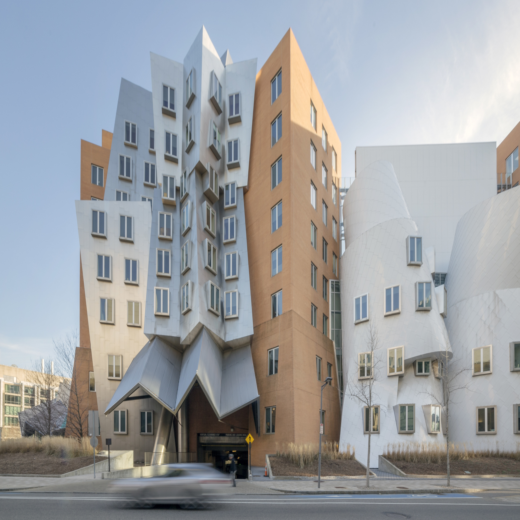

In [ ]:
import torchvision.transforms as T

!gdown 'https://drive.google.com/uc?id=1IMOCCJNXpwkn0a8Uilcq3gJQcFC-qnob'
orig_image = Image.open("stata.jpg")

to_tensor = transforms.Compose([transforms.Resize((520, 520)), transforms.PILToTensor()])
tensor = to_tensor(orig_image)
transform = T.ToPILImage()
image = transform(tensor)

image

In [ ]:
with torch.no_grad():
  # prepare the image for the model
  encoding = feature_extractor(image, return_tensors="pt")
  pixel_values = encoding.pixel_values.to(device)

  # forward pass
  outputs = model(pixel_values=pixel_values)

  # logits are of shape (batch_size, num_labels, height/4, width/4)
  logits = outputs.logits.cpu()
  print(logits.shape)

torch.Size([1, 150, 128, 128])


Classes in this image: ['wall', 'building', 'floor', 'ceiling', 'windowpane', 'cabinet', 'mountain', 'chair']


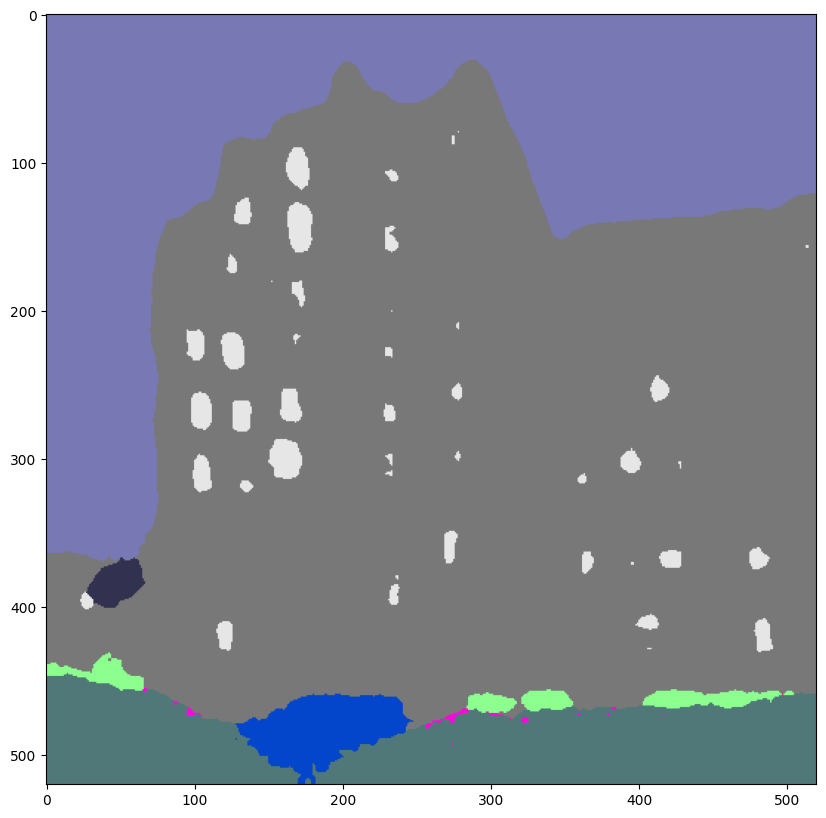

In [ ]:
# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(logits,
                size=image.size[::-1], # (height, width)
                mode='bilinear',
                align_corners=False)

# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1)[0]
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3

classes_map = np.unique(seg).tolist()
unique_classes = [model.config.id2label[idx] if idx!=255 else None for idx in classes_map]
print("Classes in this image:", unique_classes)

palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[seg == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
pred_img = np.array(image) * 0.0 + color_seg * 1
pred_img= pred_img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(pred_img)
plt.show()

Compare this to the ground truth segmentation map:

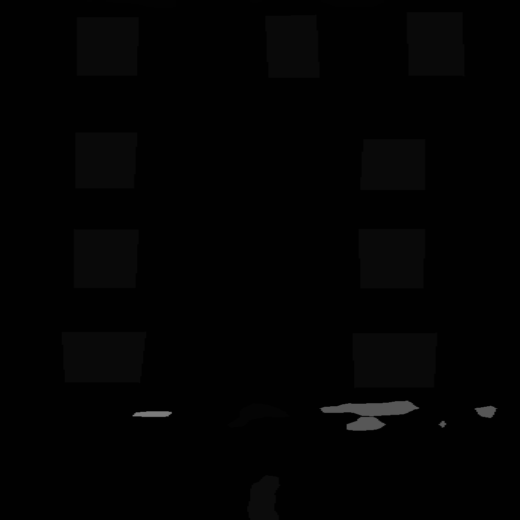

In [ ]:
annot_folder = "segformer_10_percent_dataset/annotations/testing/"
map_img = Image.open(annot_folder + img.split(".")[0]+".png")


to_tensor = transforms.Compose([transforms.Resize((520, 520)), transforms.PILToTensor()])
tensor = to_tensor(map_img)
transform = T.ToPILImage()
map = transform(tensor)

map

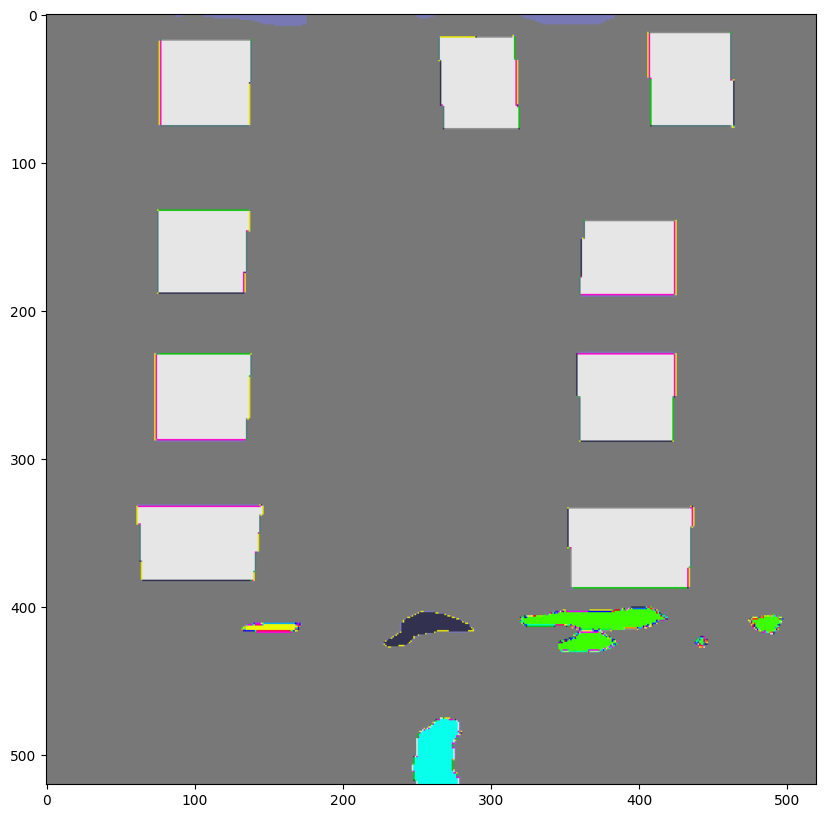

In [ ]:
# convert map to NumPy array
map = np.array(map)
map[map == 0] = 255 # background class is replaced by ignore_index
map = map - 1 # other classes are reduced by one
#map[map == 254] = 255

# create coloured map
color_seg = np.zeros((map.shape[0], map.shape[1], 3), dtype=np.uint8) # height, width, 3
palette = np.array(ade_palette())
for label, color in enumerate(palette):
    color_seg[map == label, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(image) * 0.0+ color_seg * 1.0
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()

In [ ]:
seg.unique()

tensor([0, 1, 8])

In [ ]:
model.config.id2label[37]

'bathtub'

In [ ]:
np.unique(map)

array([  0,   2,   6,   7,  82, 124, 252, 253], dtype=uint8)

In [ ]:
seg

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [ ]:
map

array([[253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253],
       ...,
       [253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253],
       [253, 253, 253, ..., 253, 253, 253]], dtype=uint8)

Let's compute the metrics:

In [ ]:
# metric expects a list of numpy arrays for both predictions and references
metrics = metric.compute(predictions=[seg.numpy()], references=[map], num_labels=150, ignore_index=255)

/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:258: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/datasets_modules/metrics/mean_iou/927b58f57da3f4b6e385e47d8a4b3947ee3f7cfcdba9b9359eba2ada2ed6b951/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


In [ ]:
metrics.keys()

dict_keys(['mean_iou', 'mean_accuracy', 'overall_accuracy', 'per_category_iou', 'per_category_accuracy'])

In [ ]:
# pretty-print per category metrics as Pandas DataFrame
metric_table = dict()

for id, label in id2label.items():
    metric_table[label] = [metrics["per_category_iou"][id],
                           metrics["per_category_accuracy"][id]]

df = pd.DataFrame.from_dict(metric_table, orient="index", columns=["IoU", "accuracy"])

iou= df.iloc[8]['IoU']
print(iou)

0.0
